# Proton data in dilepton events

### Install packages

In [ ]:
#!python3 -m pip install --user uproot4 awkward1 mplhep

In [ ]:
#!python3 -m pip show uproot4 awkward1 mplhep

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep

### N-tuple processing

The data is first processed from a ROOT n-tuple. Below is an n-tuple from an MC sample.  
Look for the _ProtCand_ data defining the proton objects.

In [2]:
import uproot4
import awkward1 as ak

root = uproot4.open( "/eos/cms/store/group/phys_pps/dilepton/DoubleMuon/UL-MiniAOD-2017/DoubleMuon_UL2017B.root" )
tree = root["ggll_miniaod/ntp1"]

print ( "Number of events in tree: {}".format( np.array( root["ggll_miniaod/ntp1/nMuonCand"] ).size ) )

keys = ["Run", "LumiSection", "BX", "EventNum", "CrossingAngle","nHLT", "HLT_Accept", "HLT_Prescl", "HLT_Name",
        "nMuonCand", "MuonCand_pt", "MuonCand_eta", "MuonCand_phi", "MuonCand_e", "MuonCand_charge", "MuonCand_vtxz", "MuonCand_istight",
        "nPrimVertexCand", "PrimVertexCand_z", "PrimVertexCand_chi2", "PrimVertexCand_ndof", "PrimVertexCand_tracks",
        "Weight", "PUWeightTrue"]
keys.append( "nPfCand" )
keys.extend( tree.keys( filter_name="PfCand*" ) ) 
keys.append( "nRecoProtCand" )
keys.extend( tree.keys( filter_name="ProtCand*" ) )

arrays = tree.arrays( keys, library="ak", how="zip", entry_stop=10000 )
#ak.to_list( arrays[:10] )
ak.to_list( arrays[100] )

Number of events in tree: 3163904


{'Run': 297227,
 'LumiSection': 53,
 'BX': 2647,
 'EventNum': 36335379,
 'CrossingAngle': 120.0,
 'nHLT': 3,
 'HLT_Name': ['HLT_DoubleMu43NoFiltersNoVtx_*',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8_*',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8_*'],
 'nMuonCand': 2,
 'nPrimVertexCand': 13,
 'Weight': 1.0,
 'PUWeightTrue': 0.0,
 'nPfCand': 39,
 'nRecoProtCand': 6,
 'HLT': [{'Accept': -1, 'Prescl': -1},
  {'Accept': -1, 'Prescl': -1},
  {'Accept': 1, 'Prescl': 1}],
 'MuonCand': [{'pt': 34.08102798461914,
   'eta': -1.1280056238174438,
   'phi': 0.08699752390384674,
   'e': 58.16221433126572,
   'charge': -1,
   'vtxz': 1.7735739946365356,
   'istight': 1},
  {'pt': 30.047592163085938,
   'eta': 0.5885106325149536,
   'phi': -2.901550769805908,
   'e': 35.40308889190446,
   'charge': 1,
   'vtxz': 1.7737929821014404,
   'istight': 1}],
 'PrimVertexCand': [{'z': 1.775673270225525,
   'chi2': 38.469783782958984,
   'ndof': 39,
   'tracks': 0},
  {'z': 4.6346001625061035,
   'chi2': 

The n-tuples are processed and the following event selection is applied:  

* Events are selected with unprescaled dimuon HLT triggers
* The two leading muons are required with transverse momentum larger than 50 GeV, to be of opposite charge and associated to the primary vertex in the longitudinal direction

The acoplanarity is defined as $1 - \lvert\Delta\phi(\mu\mu)\rvert/\pi$, where $\Delta\phi(\mu\mu)$ is the azimuthal angle difference between the two leading muons.

The number of extra tracks is calculated as those originating from the primary vertex which are separated in the azimuthal angle and pseudorapidity space from the two leading muons.

The data is then _flattened_ over the proton objects, as will be seen below.

### Proton reconstruction flavours

We will look at two ways to reconstruct protons in PPS: _single-RP_ and _multi-RP_

The flag below controls which proton reconstruction is used.

In the multi-RP reconstruction, both "near" and "far" tracking detector stations in one spectrometer arm are used. 

In the single-RP reconstruction, the proton kinematics is only partially reconstructed from a single detector station. In this case we will use the "far" station. In the 2017 detector configuration, this corresponds to the stations using pixel detectors.

In [3]:
fileName_signal = "/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-MC2017-Elastic-Non3+3-PreSel.h5"
#fileName_signal = "/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-MC2017-SingleDissociation-Non3+3-PreSel.h5"

fileNames_data = [
    '/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-UL2017B-PreSel.h5',
    '/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-UL2017C1-PreSel.h5',
    '/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-UL2017E-PreSel.h5',
    '/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-UL2017F1-PreSel.h5'
]

#proton_selection = "SingleRP"
proton_selection = "MultiRP"

# Signal

## Access the data

In [4]:
df_signal = None
event_counts_signal = None
selections_str_signal = None

with h5py.File( fileName_signal, 'r' ) as f:
    print ( list(f.keys()) )
    dset = f['protons']
    print ( dset.shape )
    print ( dset[:,:] )
    dset_columns = f['columns']
    print ( dset_columns.shape )
    columns = list( dset_columns )
    print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    print ( columns_str )
    
    dset_counts = f['event_counts']
    event_counts_signal = list( dset_counts )
    print ( event_counts_signal )
    
    dset_selections = f['selections']
    selections_ = list( dset_selections )
    print ( selections_ )
    selections_str_signal = [ item.decode("utf-8") for item in selections_ ]
    print ( selections_str_signal )
    
    df_signal = pd.DataFrame( dset, columns=columns_str )
    
    df_signal = df_signal[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                            'Xi', 'T', 'ThX', 'ThY',
                            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
    

['columns', 'event_counts', 'protons', 'selections']
(213536, 38)
[[1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 9.1376482e-04
  2.3529863e-02 4.4119707e-03]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 ...
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 2.6697566e-04
  2.1097749e-03 4.5376737e-02]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muo

In [5]:
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,T,ThX,ThY,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,1,1,5,150.0,0,-999,23,-1,2.218964,0.249985,...,-1.530517,0.000000,-0.000193,63.039753,62.647861,132.454605,34,0.000914,0.023530,0.004412
1,1,1,3,150.0,0,-999,103,-1,7.630859,1.224731,...,-0.039389,0.000000,-0.000027,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510
2,1,1,3,150.0,0,-999,123,-1,7.794434,1.300049,...,-0.037168,0.000000,-0.000026,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510
3,1,1,3,150.0,1,1,103,123,7.630859,1.224731,...,-0.432312,0.000102,0.000023,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510
4,1,1,12,150.0,0,-999,3,-1,5.149414,0.725220,...,-0.107853,0.000000,-0.000051,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708
5,1,1,12,150.0,0,-999,23,-1,5.103577,0.700012,...,-0.080861,0.000000,-0.000044,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708
6,1,1,12,150.0,1,0,3,23,5.149414,0.725220,...,-0.058947,-0.000036,0.000011,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708
7,1,1,15,150.0,0,-999,103,-1,4.258057,2.774658,...,-0.781266,0.000000,-0.000140,89.590111,88.274399,195.115387,10,0.000011,0.003281,0.068651
8,1,1,15,150.0,0,-999,123,-1,4.074829,3.050049,...,-0.817653,0.000000,-0.000143,89.590111,88.274399,195.115387,10,0.000011,0.003281,0.068651
9,1,1,10,150.0,0,-999,3,-1,3.106201,0.438080,...,-0.467230,0.000000,-0.000107,62.715733,61.223686,180.117294,0,0.001280,0.029329,0.006546


In [6]:
df_counts_signal = pd.Series( event_counts_signal, index=selections_str_signal );
df_counts_signal

All        178402
Muon       166756
Vertex     149608
Protons     91429
dtype: int64

Text(0.5, 0, 'Number of $\\it{extra}$ tracks')

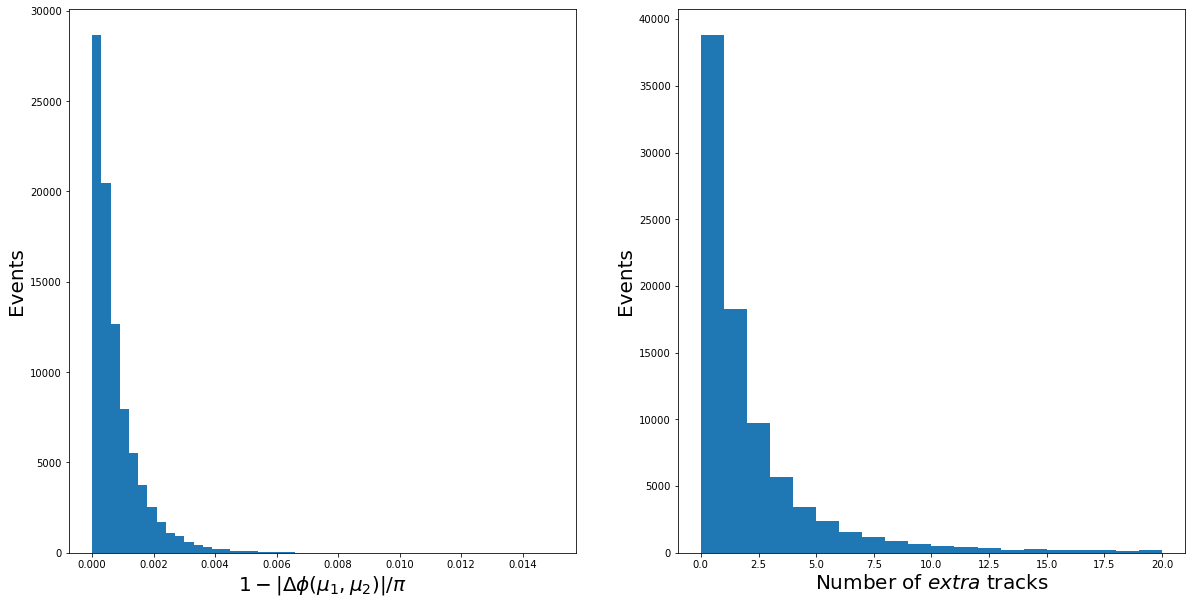

In [7]:
df_signal_events = df_signal.set_index( ["Run", "LumiSection", "EventNum"] ).drop( columns=['Xi', 'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2'] )
df_signal_events = df_signal_events[ ~df_signal_events.index.duplicated(keep='first') ]

msk_invmass = ( df_signal_events["InvMass"] >= 110. )
df_signal_events = df_signal_events[msk_invmass]

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist( df_signal_events["Acopl"], bins=50, range=(0.,0.015) )
axes[0].set_ylabel( "Events", fontsize=20 )
axes[0].set_xlabel( r"$1 - \vert\Delta\phi(\mu_1,\mu_2)\vert/\pi$", fontsize=20 )
axes[1].hist( df_signal_events["ExtraPfCands"], bins=20, range=(0,20) )
axes[1].set_ylabel( "Events", fontsize=20 )
axes[1].set_xlabel( r"Number of $\it{extra}$ tracks", fontsize=20 )

Text(0, 0.5, 'Y (mm)')

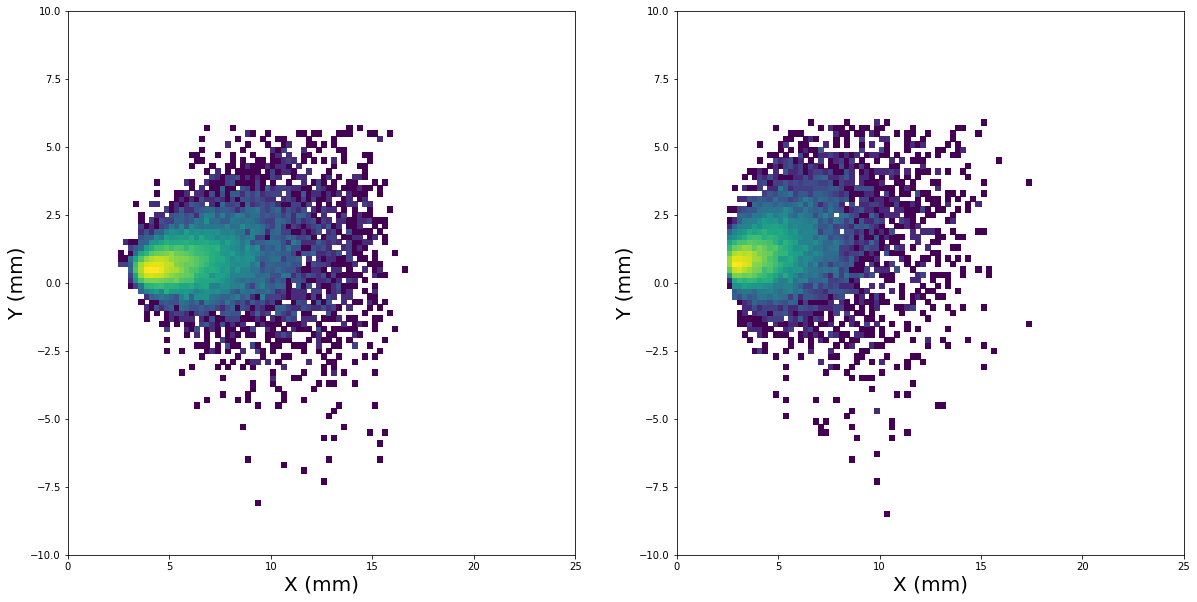

In [8]:
from matplotlib.colors import LogNorm

msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_signal[ "TrackX1" ][ msk_protons_1 ], df_signal[ "TrackY1" ][ msk_protons_1 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_signal[ "TrackX1" ][ msk_protons_2 ], df_signal[ "TrackY1" ][ msk_protons_2 ], bins=(100,100), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: MultiRP
Number of protons: 16514, 15465


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

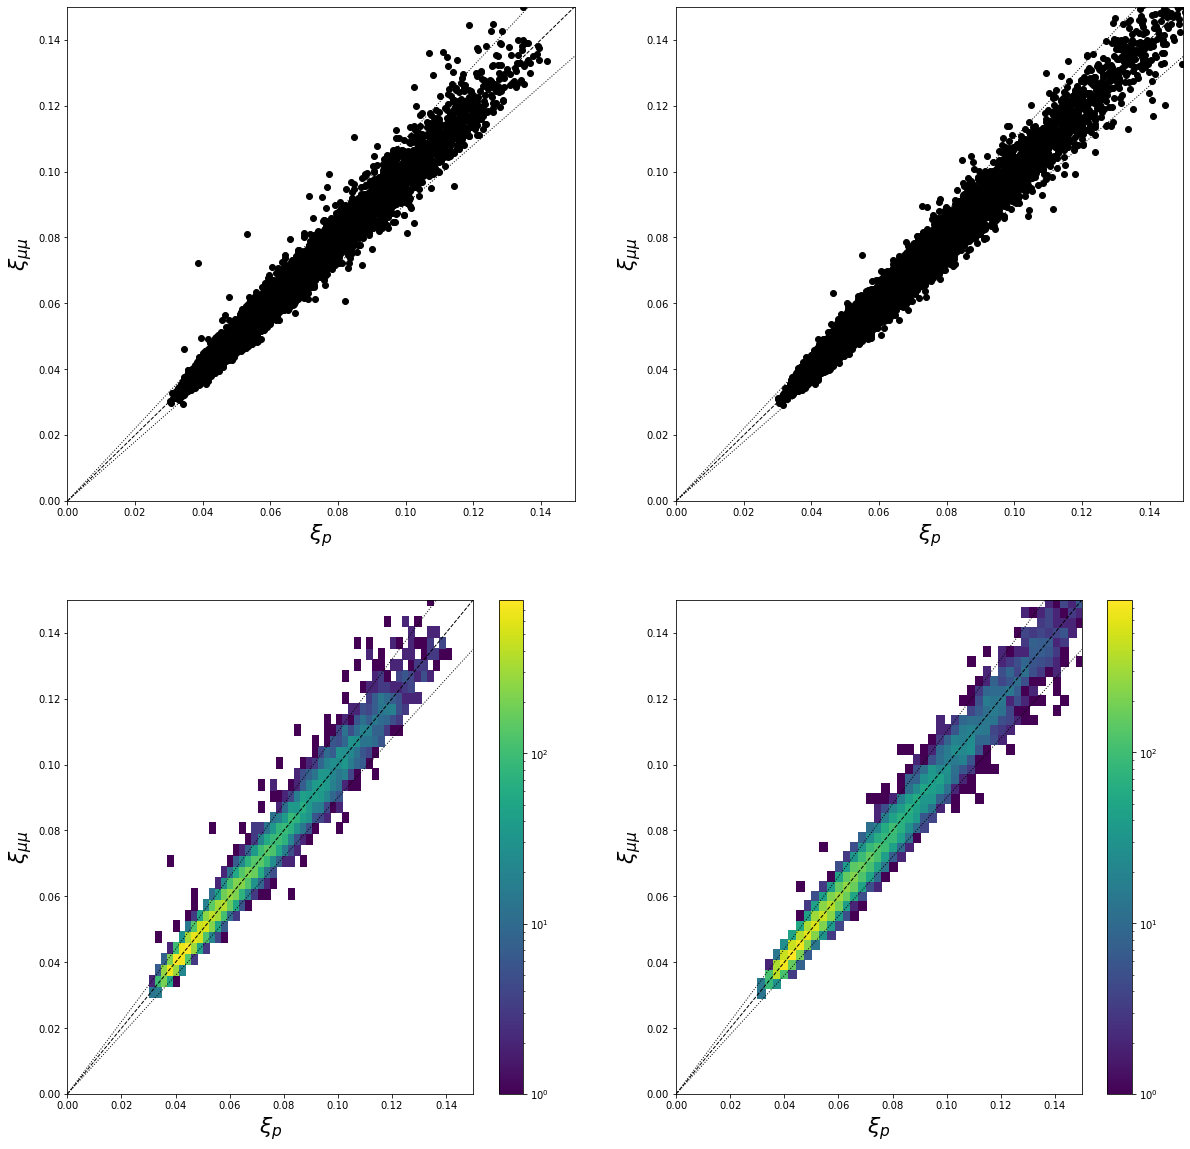

In [9]:
msk_excl = ( df_signal["InvMass"] >= 110. ) & ( df_signal["Acopl"] <= 0.009 ) & ( df_signal["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 0) & ( df_signal["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_signal["MultiRP"] == 1 ) & ( df_signal["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_signal[ "Xi" ][ msk_protons_1 ] ), len( df_signal[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
#axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22, ha='right', x=1.0 )
#axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22, ha='right', y=1.0 )
axes[0,1].plot( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_signal[ "Xi" ][ msk_protons_1 ], df_signal[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_signal[ "Xi" ][ msk_protons_2 ], df_signal[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )

# Data

In [10]:
df_data_list = []
df_counts_data_list = []

for file_ in fileNames_data:
    print ( file_ )
    with h5py.File( file_, 'r' ) as f:    
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
    
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )  
        
        dset_counts = f['event_counts']
        df_counts_data_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_data_list[-1] )
    
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        print ( start_ )
        print ( stop_ )
        for idx in range( len( start_ ) ):
            print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                        'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                        'Xi', 'T', 'ThX', 'ThY',
                        'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
            df_data_list.append( df_ )
            print ( df_data_list[-1].head() )
            print ( len( df_data_list[-1] ) )
            
print ( "Concatenating {} dataframes..".format( len( df_data_list ) ) )
df_data = pd.concat( df_data_list )
print ( "Total length: {} lines".format( len( df_data ) ) )
df_data[:20]

/eos/user/c/cmsdas/short-exercises/pps-protons-tutorial/data/output-UL2017B-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(107075, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.5000000e+01 8.6700000e+02 ... 1.3261172e-01
  1.9532344e-03 4.8346210e-02]
 [2.9722700e+05 5.5000000e+01 8.6700000e+02 ... 1.3261172e-01
  1.9532344e-03 4.8346210e-02]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b

[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', b'Muon0Pt', b'Muon0Eta', b'Muon0Phi', b'Muon0VtxZ', b'Muon1Pt', b'Muon1Eta', b'Muon1Phi', b'Muon1VtxZ', b'PrimVertexZ', b'InvMass', b'ExtraPfCands', b'Acopl', b'XiMuMuPlus', b'XiMuMuMinus']
['Run', 'LumiSection', 'BX', 'EventNum', 'CrossingAngle', 'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2', 'Xi', 'T', 'ThX', 'ThY', 'Time', 'TrackThX_SingleRP', 'TrackThY_SingleRP', 'Track1ThX_MultiRP', 'Track1ThY_MultiRP', 'Track2ThX_MultiRP', 'Track2ThY_MultiRP', 'Muon0Pt', 'Muon0Eta', 'Muon0Phi', 'Muon0VtxZ', 'Muon1Pt', 'Muon1Eta', 'Muon1Phi', 'Muon1VtxZ', 'PrimVertexZ', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus']
['All', 'Muon', 

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,T,ThX,ThY,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus
0,297227,53,36577200,120.0,0,-999,123,-1,2.333649,0.503052,...,-0.659534,0.000000,-0.000127,132.996933,63.807861,12.129827,48,0.983012,0.056195,0.004091
1,297227,55,38079656,120.0,0,-999,103,-1,4.577393,1.367676,...,-0.327952,0.000000,-0.000090,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346
2,297227,55,38079656,120.0,0,-999,123,-1,4.395691,1.493408,...,-0.332531,0.000000,-0.000091,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346
3,297227,55,38079656,120.0,1,1,103,123,4.577393,1.367676,...,-0.160121,-0.000061,-0.000014,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346
4,297227,56,38791640,120.0,0,-999,103,-1,8.585938,2.644531,...,-0.184990,0.000000,-0.000068,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855
5,297227,56,38791640,120.0,0,-999,123,-1,8.483521,2.801025,...,-0.181088,0.000000,-0.000067,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855
6,297227,56,38791640,120.0,1,1,103,123,8.585938,2.644531,...,-0.039719,-0.000015,0.000024,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855
7,297227,56,38604580,120.0,0,-999,3,-1,4.131104,0.797180,...,-0.663142,0.000000,-0.000128,74.027679,70.969543,90.916580,28,0.588286,0.003354,0.038210
8,297227,56,38604580,120.0,0,-999,23,-1,4.206665,0.942139,...,-0.536933,0.000000,-0.000115,74.027679,70.969543,90.916580,28,0.588286,0.003354,0.038210
9,297227,56,38604580,120.0,0,-999,103,-1,3.514526,1.507568,...,-1.146207,0.000000,-0.000168,74.027679,70.969543,90.916580,28,0.588286,0.003354,0.038210


In [11]:
df_counts_data = df_counts_data_list[0];
for idx in range( 1, len(df_counts_data_list) ):
    df_counts_data = df_counts_data.add( df_counts_data_list[idx] )
df_counts_data

All        43455978
Muon         422801
Vertex       389118
Protons      315084
dtype: int64

Text(0, 0.5, 'Y (mm)')

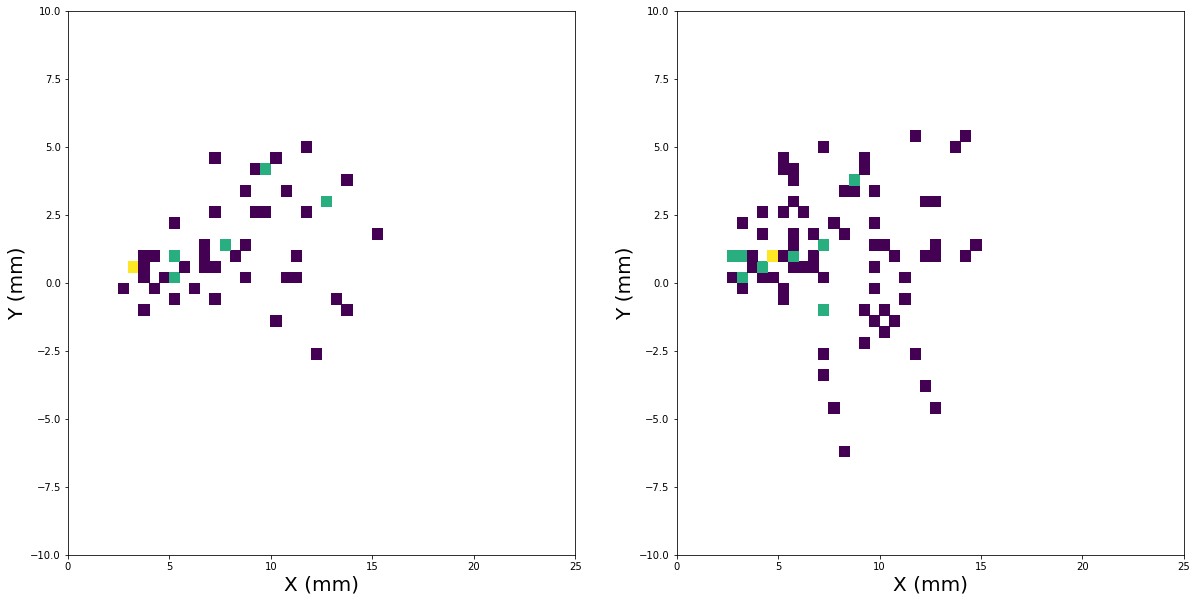

In [12]:
msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )
    
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )
axes[0].hist2d( df_data[ "TrackX1" ][ msk_protons_1 ], df_data[ "TrackY1" ][ msk_protons_1 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[0].set_xlabel( "X (mm)", fontsize=20 )
axes[0].set_ylabel( "Y (mm)", fontsize=20 )
axes[1].hist2d( df_data[ "TrackX1" ][ msk_protons_2 ], df_data[ "TrackY1" ][ msk_protons_2 ], bins=(50,50), range=( (0.,25.), (-10.,10.) ), norm=LogNorm(), cmap='viridis' )
axes[1].set_xlabel( "X (mm)", fontsize=20 )
axes[1].set_ylabel( "Y (mm)", fontsize=20 )

Proton selection: MultiRP
Number of protons: 52, 85


Text(0, 0.5, '$\\xi_{\\mu\\mu}$')

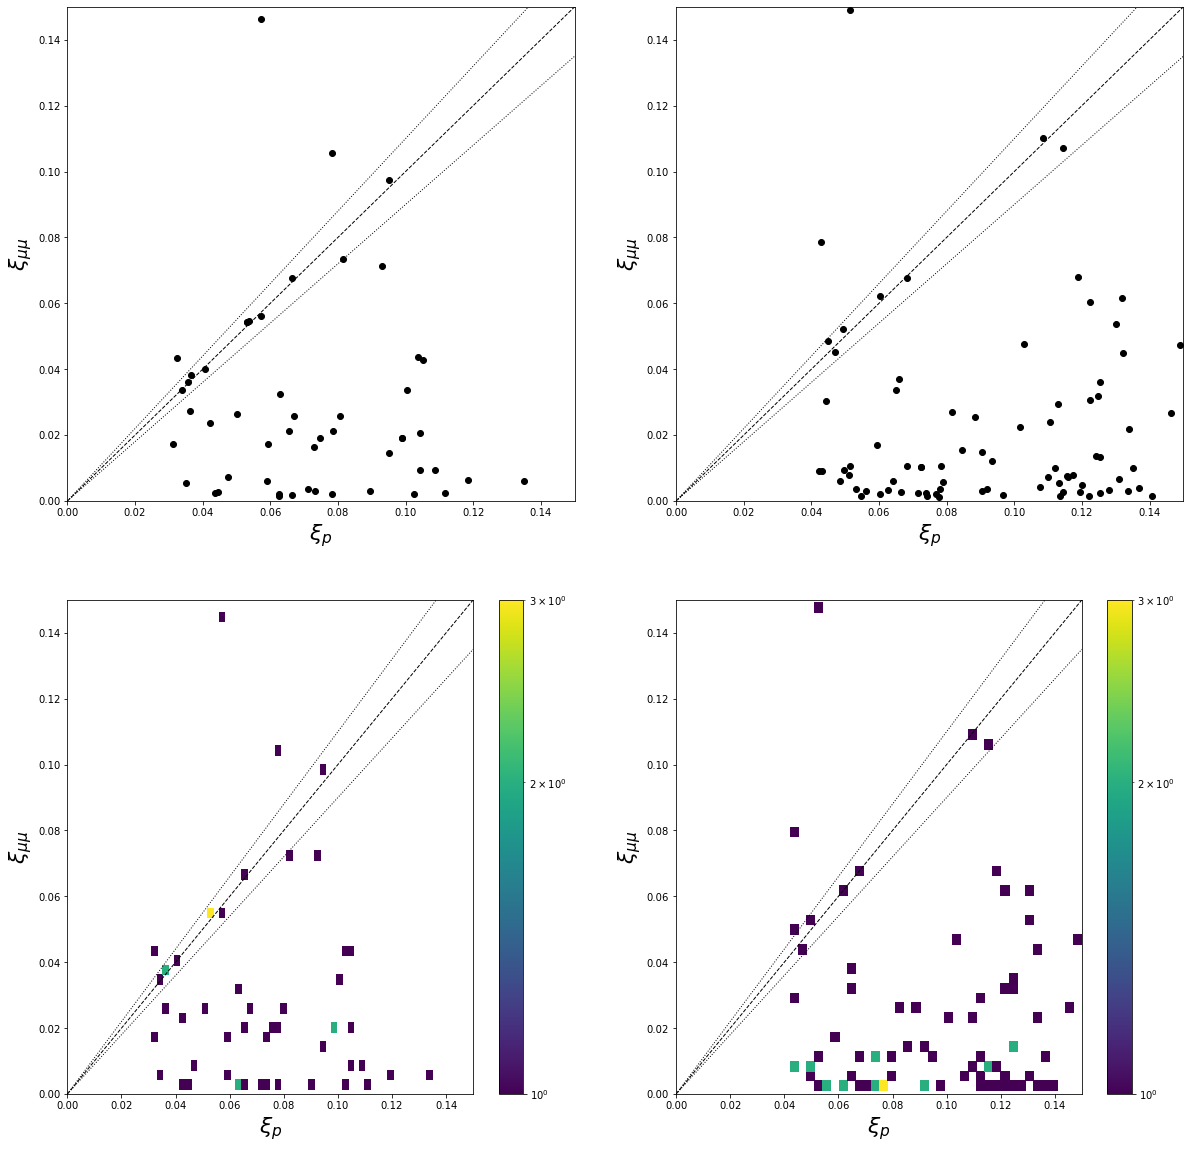

In [13]:
msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )

print ( "Proton selection: {}".format( proton_selection ) )
print ( "Number of protons: {}, {}".format( len( df_data[ "Xi" ][ msk_protons_1 ] ), len( df_data[ "Xi" ][ msk_protons_2 ] ) ) )

fig, axes = plt.subplots( 2, 2, figsize=(20,20) )
axes[0,0].plot( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], 'ko' )
axes[0,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,0].set_xlim(0.,0.15)
axes[0,0].set_ylim(0.,0.15)
axes[0,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
axes[0,1].plot( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], 'ko' )
axes[0,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0,1].set_xlim(0.,0.15)
axes[0,1].set_ylim(0.,0.15)
axes[0,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[0,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,0].hist2d( df_data[ "Xi" ][ msk_protons_1 ], df_data[ "XiMuMuPlus" ][ msk_protons_1 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,0])
axes[1,0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,0].set_xlim(0.,0.15)
axes[1,0].set_ylim(0.,0.15)
axes[1,0].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,0].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )
counts, xedges, yedges, im = axes[1,1].hist2d( df_data[ "Xi" ][ msk_protons_2 ], df_data[ "XiMuMuMinus" ][ msk_protons_2 ], bins=(50,50), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=axes[1,1])
axes[1,1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1,1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1,1].set_xlim(0.,0.15)
axes[1,1].set_ylim(0.,0.15)
axes[1,1].set_xlabel( r"$\xi_p$", fontsize=22 )
axes[1,1].set_ylabel( r"$\xi_{\mu\mu}$", fontsize=22 )

### Select dilepton candidates in diagonal

[0 0 0 2 1 0 0 1 0 0 1 1 1 0 2 1 0 2 1 0 3 1 0 2 4 7 2 0 1 0 0 0 0 0 0 0 0
 0 0 0] [-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3. ]
[0 0 2 1 0 1 2 2 0 0 3 0 3 0 2 1 0 1 0 3 1 2 1 0 3 4 0 1 1 0 0 0 0 0 0 0 0
 0 0 0] [-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4
  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3. ]
y max. = 12.291502622129181


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


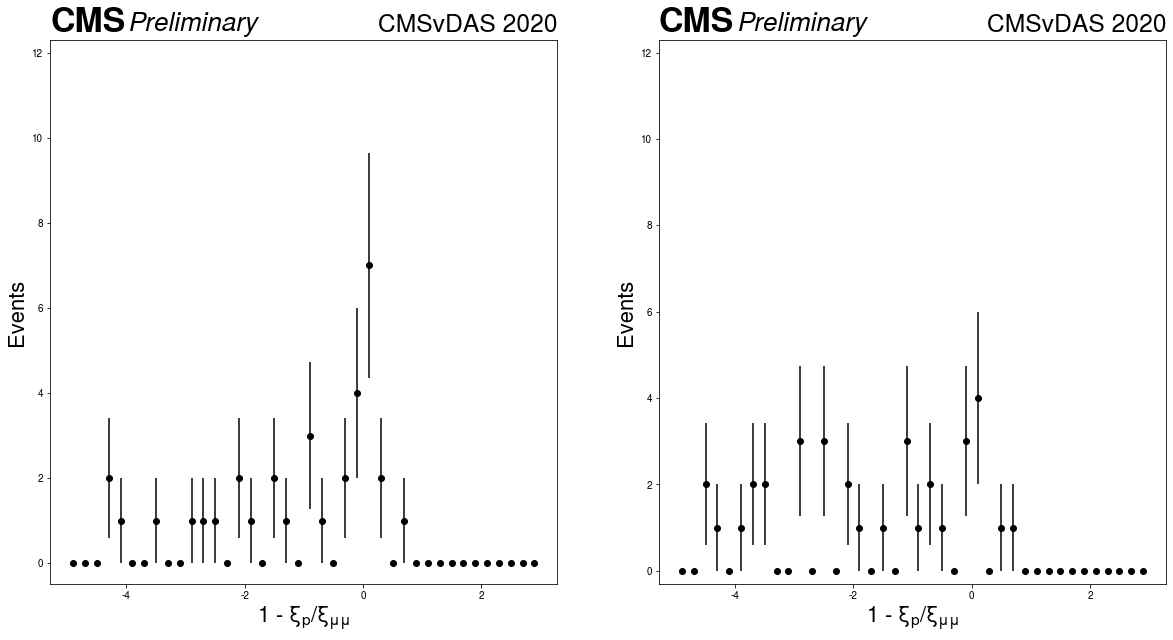

In [15]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

bins_ = 40
range_ = (-5.,3.)

msk_excl = ( df_data["InvMass"] >= 110. ) & ( df_data["Acopl"] <= 0.009 ) & ( df_data["ExtraPfCands"] <= 1 )

msk_protons_1 = None
msk_protons_2 = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 23 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 0) & ( df_data["RPId1"] == 123 )
elif proton_selection == "MultiRP":
    # Multi-RP
    msk_protons_1 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 0 )
    msk_protons_2 = msk_excl & ( df_data["MultiRP"] == 1 ) & ( df_data["Arm"] == 1 )
    
vals_1 = ( 1. - df_data[ "Xi" ][ msk_protons_1 ] / df_data[ "XiMuMuPlus" ][ msk_protons_1 ] )
counts_1, bin_edges_1 = np.histogram( vals_1, bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
print ( counts_1, bin_edges_1 )

bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='ko')

vals_2 = ( 1. - df_data[ "Xi" ][ msk_protons_2 ] / df_data[ "XiMuMuMinus" ][ msk_protons_2 ] )
counts_2, bin_edges_2 = np.histogram( vals_2, bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
print ( counts_2, bin_edges_2 )

bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='ko')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

axes[0].set_ylim( top=y_max )
axes[0].set_xlabel( r"1 - $\xi_p / \xi_{\mu\mu}$", fontsize=22 )
axes[0].set_ylabel( "Events", fontsize=22 )
axes[1].set_ylim( top=y_max )
axes[1].set_xlabel( r"1 - $\xi_p / \xi_{\mu\mu}$", fontsize=22 )
axes[1].set_ylabel( "Events", fontsize=22 )

plt.style.use(mplhep.style.CMS)
plt.sca( axes[0] )
mplhep.cms.label(llabel="Preliminary", rlabel="CMSvDAS 2020")
plt.sca( axes[1] )
mplhep.cms.label(llabel="Preliminary", rlabel="CMSvDAS 2020")

### Plot proton variables

5785      0.066331
39811     0.053652
45170     0.040781
936       0.057313
93817     0.081479
157144    0.095002
197500    0.035533
13880     0.053052
27904     0.036581
108797    0.033968
276753    0.053052
Name: Xi, dtype: float32
101961    0.047040
47139     0.114364
102511    0.108525
183292    0.049287
254521    0.060402
347199    0.044985
398981    0.068187
Name: Xi, dtype: float32
y max. = 9.47213595499958
5785      0.000026
39811     0.000088
45170    -0.000064
936       0.000047
93817    -0.000030
157144    0.000017
197500    0.000017
13880    -0.000006
27904    -0.000037
108797    0.000101
276753   -0.000006
Name: ThX, dtype: float32
101961    0.000113
47139     0.000029
102511   -0.000069
183292    0.000063
254521   -0.000008
347199    0.000013
398981    0.000080
Name: ThX, dtype: float32
y max. = 9.47213595499958
5785     -1.711910e-05
39811     7.711315e-07
45170    -5.318766e-05
936       3.860024e-06
93817    -1.272517e-05
157144   -3.580272e-05
197500   -5.277169e-05
1

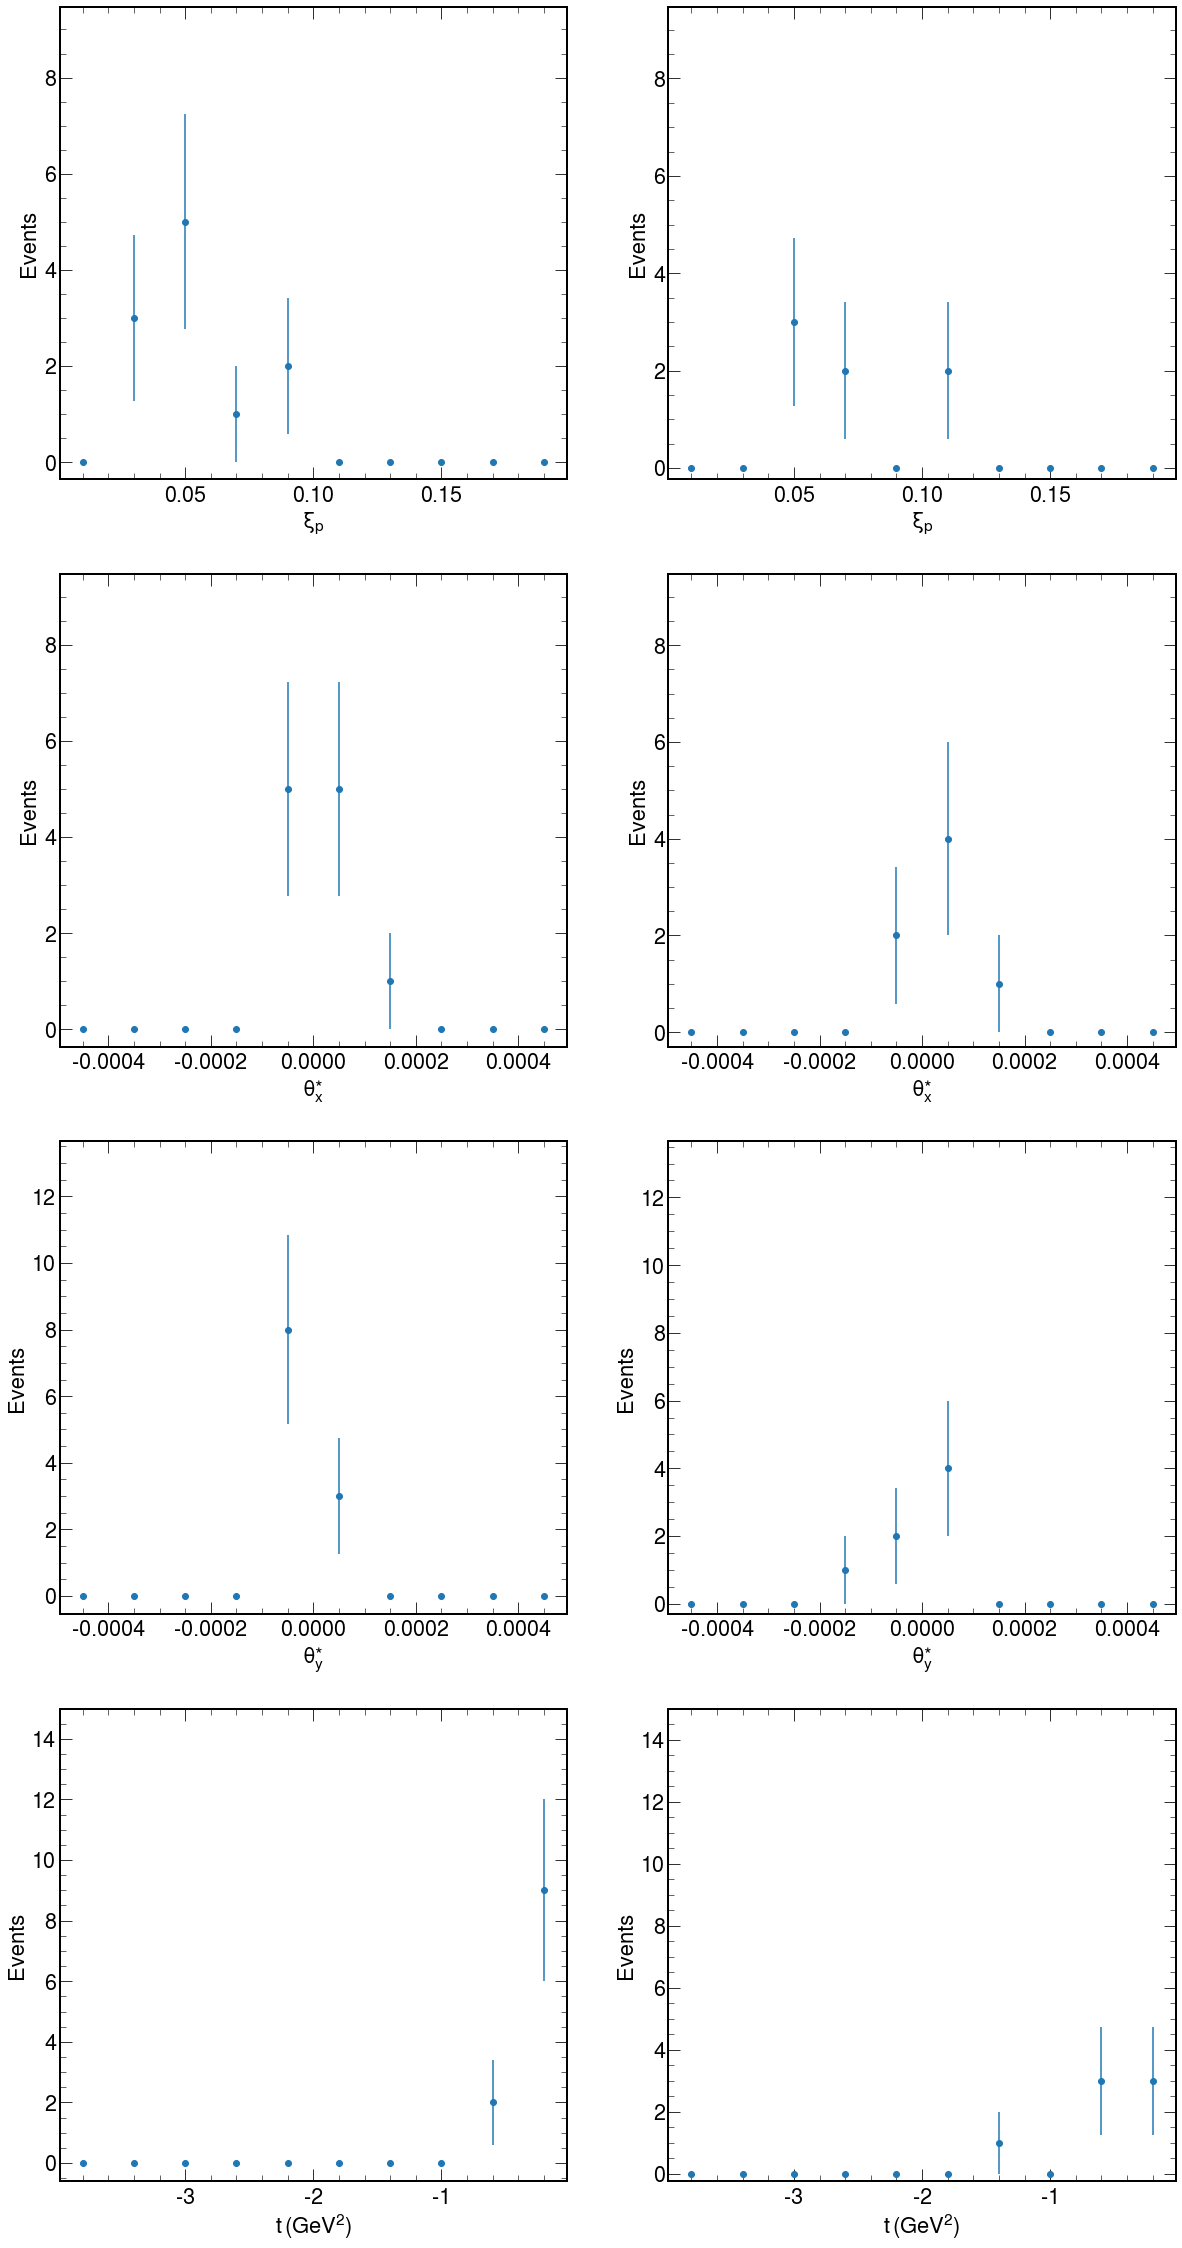

In [16]:
msk1_data_sel = ( vals_1 >= -0.20 ) & ( vals_1 <= +0.20 )
msk2_data_sel = ( vals_2 >= -0.20 ) & ( vals_2 <= +0.20 )

vars_ = {
    "Xi": { "var" : "Xi", "bins" : 10, "range" : (0.,0.2), "xlabel" : r"$\xi_p$" },
    "ThX": { "var" : "ThX", "bins" : 10, "range" : (-0.0005,0.0005), "xlabel" : r"$\theta_x^{\ast}$" },
    "ThY": { "var" : "ThY", "bins" : 10, "range" : (-0.0005,0.0005), "xlabel" : r"$\theta_y^{\ast}$" },
    "T": { "var" : "T", "bins" : 10, "range" : (-4.,0.), "xlabel" : r"$t\,(\mathrm{GeV}^2)$" }
    }

fig, axes = plt.subplots( len( vars_ ), 2, figsize=( 20, 10*len( vars_ ) ) )

row_ = 0
for key_ in vars_:

    var_ = vars_[ key_ ][ "var" ]
    bins_ = vars_[ key_ ][ "bins" ]
    range_ = vars_[ key_ ][ "range" ]
    xlabel_ = vars_[ key_ ][ "xlabel" ]
    
    print ( df_data[ var_ ][ msk_protons_1 ][ msk1_data_sel ] )

    counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_protons_1 ][ msk1_data_sel ], bins=bins_, range=range_ )
    errors_1 = np.sqrt( counts_1 )
    bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
    axes[ row_, 0 ].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

    print ( df_data[ var_ ][ msk_protons_2 ][ msk2_data_sel ] )

    counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_protons_2 ][ msk2_data_sel ], bins=bins_, range=range_ )
    errors_2 = np.sqrt( counts_2 )
    bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
    axes[ row_, 1 ].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

    idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
    y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
    print ( "y max. = {}".format(y_max) )

    axes[ row_, 0 ].set_ylim( top=y_max )
    axes[ row_, 0 ].set_xlabel( xlabel_, fontsize=22 )
    axes[ row_, 0 ].set_ylabel( "Events", fontsize=22 )
    axes[ row_, 1 ].set_ylim( top=y_max )
    axes[ row_, 1 ].set_xlabel( xlabel_, fontsize=22 )
    axes[ row_, 1 ].set_ylabel( "Events", fontsize=22 )
    
    row_ += 1
    